# Quantum Algorithms

In [35]:
from openql import openql as ql
import random
from utils import simulate, plot_histogram


In [36]:
ql.initialize()
compiler = ql.Compiler("compiler", "./compiler-config.json")

platform = ql.Platform("platform", "none")
platform.set_compiler(compiler=compiler)


## Bernstein-Vazirani Algorithm

In [37]:
N = 5  # length of the secret message
secret = f"{random.randint(0, 2**N - 1):0{N}b}"  # generate secret message

secret


'00100'

In [38]:
bv_program = ql.Program("bernstein-vazirani", platform=platform, qubit_count=N + 1)
bv_kernel = ql.Kernel("bv-kernel", platform=platform, qubit_count=N + 1)

# apply Hadamard gate to first N qubits
for qubit in range(N):
    bv_kernel.hadamard(qubit)

# apply X gate and Hadamard gate to the last qubit
bv_kernel.x(N)
bv_kernel.hadamard(N)

# oracle
for i in range(N):
    if int(secret[i]) == 1:
        bv_kernel.cnot(i, N)

# reverse Hadamards and measure
for qubit in range(N):
    bv_kernel.hadamard(qubit)
    bv_kernel.measure(qubit)

bv_program.add_kernel(bv_kernel)
bv_program.compile()


In [39]:
counts = simulate(program=bv_program, measured=range(N), shots=1)


In [40]:
print(f"{counts=}")
print(f"{secret=}")


counts={'00100': 1}
secret='00100'


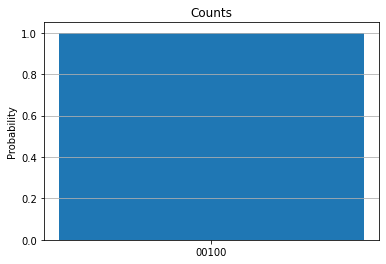

In [41]:
plot_histogram(counts=counts)


## Teleportation Algorithm

In [42]:
tp_program = ql.Program("teleportation", platform=platform, qubit_count=3)
tp_kernel = ql.Kernel("tp-kernel", platform=platform, qubit_count=3)

# prepare state that will be sent, ie |1>
tp_kernel.x(0)

# create bell state for Alice and Bob
tp_kernel.hadamard(1)
tp_kernel.cnot(1, 2)

# expansion in Bell's basis by Alice
tp_kernel.cnot(0, 1)
tp_kernel.hadamard(0)

# Bob's state translation
tp_kernel.cnot(1, 2)
tp_kernel.cz(0, 2)

# make measurements
tp_kernel.measure(0)
tp_kernel.measure(1)
tp_kernel.measure(2)

tp_program.add_kernel(tp_kernel)
tp_program.compile()


In [43]:
counts = simulate(program=tp_program, shots=1024)


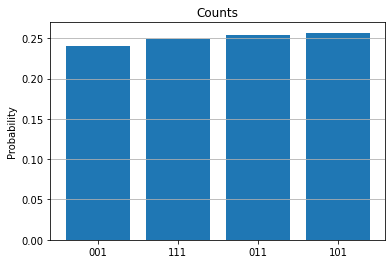

In [44]:
plot_histogram(counts)


In [45]:
counts = simulate(program=tp_program, measured=[2], shots=1024)


In [46]:
counts


{'1': 1024}